In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import transform,feature,exposure
import pickle

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.externals import joblib


In [2]:
def readTrafficSigns(rootpath):
    images = [] # images
    labels = [] # corresponding labels
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        gtReader.next() # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [3]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


def showimg_n_hog(grayimg,hogImage):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
    ax1.axis('off')
    ax1.imshow(grayimg)
    ax1.set_title('Input image')
    ax1.set_adjustable('box-forced')

    ax2.axis('off')
    ax2.imshow(hogImage, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box-forced')
    plt.show()

In [4]:
if os.path.isfile("Image_n_Labels/trainImages.npy") &  os.path.isfile("Image_n_Labels/trainLabels.npy") :
    X = np.load("Image_n_Labels/trainImages.npy")
    y = np.load("Image_n_Labels/trainLabels.npy")
    print("[INFO] Training images and labels are loaded in variables ==> X,y")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(X), len(y)))
    
else:
    trainImages, trainLabels =readTrafficSigns("/home/nikita/Downloads/gtsrb/dataset/GTSRB_finaltraining/Final_Training/Images")
    np.save("Image_n_Labels/trainImages.npy",trainImages)
    np.save("Image_n_Labels/trainLabels.npy",trainLabels)
    print("[INFO] training images and labels are read from the dataset directory")
    print("[INFO] training images saved to Image_n_Labels/trainingImages.npy for further use")
    print("[INFO] training labels saved to Image_n_Labels/trainingLabels.npy for further use")
    X = np.load("Image_n_Labels/trainImages.npy")
    y = np.load("Image_n_Labels/trainLabels.npy")

[INFO] training images and labels are read from the dataset directory
[INFO] training images saved to Image_n_Labels/trainingImages.npy for further use
[INFO] training labels saved to Image_n_Labels/trainingLabels.npy for further use


In [5]:
def get_csv(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.csv')]

In [6]:
def loadtestimages_from_path(testpath):
    print("[INFO] reading all test images from directory\n")
    gtFile=get_csv(testpath);
    filename = gtFile[0]
    raw_data = open(filename, 'rt')
    reader = csv.reader(raw_data, delimiter=';')
    reader.next()
    testfiles = list(reader)
    timg = []
    testimg = []
    for row in testfiles:
        fname = os.path.join(testpath,row[0])
        timg.append(fname)
        testimg.append(plt.imread(fname))
    return timg,testimg


In [7]:
if (os.path.isfile("Image_n_Labels/testimagenames.npy") &  os.path.isfile("Image_n_Labels/testimages.npy")):
    print("[INFO] loading from .npy\n")
    timg = np.load("Image_n_Labels/testimagenames.npy")
    testimg = np.load("Image_n_Labels/testimages.npy")
    print("[INFO] DONE!loaded from .npy\n")
    print("[INFO] Training images and labels are loaded in variables ==> X,y")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(timg), len(testimg)))
else:
    testpath="/home/nikita/Downloads/gtsrb/dataset/GTSRB_finaltest/Final_Test/Images"
    timg,testimg = loadtestimages_from_path(testpath)
    np.save("Image_n_Labels/testimagenames.npy",timg)
    np.save("Image_n_Labels/testimages.npy",testimg)
    
    
    

[INFO] loading from .npy

[INFO] DONE!loaded from .npy

[INFO] Training images and labels are loaded in variables ==> X,y
[INFO] Number of training Images 12630 
Number of Labels 12630


[INFO] There are total 12630 test images availabe
[INFO] Example /home/nikita/Downloads/gtsrb/dataset/GTSRB_finaltest/Final_Test/Images/00004.ppm


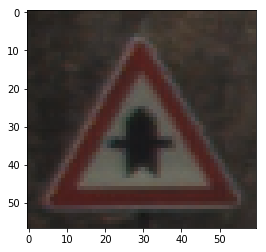

In [8]:
print("[INFO] There are total {} test images availabe".format(len(timg)))
print("[INFO] Example {}".format(timg[4]))
plt.imshow(plt.imread(timg[4]))
plt.show()

In [9]:
n = np.random.randint(0,len(X))
i1 = X[29]
grayim = rgb2gray(i1)
gI1 = transform.resize(grayim,(40,40))
(H, hogImage) = feature.hog(gI1, orientations=9, pixels_per_cell=(4,4),cells_per_block=(2, 2), transform_sqrt=True, visualise=True)

hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")

/home/nikita/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/nikita/anaconda2/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [10]:
if os.path.isfile("HoGFeatures/HoGfeatures.npy") & os.path.isfile("HoGFeatures/HoGvisualize.npy") :
    print("[INFO] loading from file ... ")
    hogfeat = np.load("HoGFeatures/HoGfeatures.npy")
    hogviz = np.load("HoGFeatures/HoGvisualize.npy")
    
    print("HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat")
    print("HoG visualizations are loaded from HoGvisualize.npy to variable ==> hogviz")
    
else:
    Hviz=[]
    Hfeat=[]
    print("[INFO] HoGfeatures.npy does not exist")
    for i in range(len(X)):
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X)))
        i1 = X[i]
        grayim = rgb2gray(i1)
        gI1 = transform.resize(grayim,(40,40))
        (H, hogImage) = feature.hog(gI1, orientations=9, pixels_per_cell=(4,4),cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")

        Hviz.append(hogImage)
        Hfeat.append(H)

    np.save("HoGFeatures/HoGfeatures.npy", Hfeat)
    np.save("HoGFeatures/HoGvisualize.npy", Hviz)
    print("[INFO] HoGfeatures.npy are saved")  
    print("[INFO] HoGvisualize.npy are saved")
    hogfeat = np.load("HoGFeatures/HoGfeatures.npy")
    hogviz = np.load("HoGFeatures/HoGvisualize.npy")

[INFO] HoGfeatures.npy does not exist
[INFO] processed 1000/39209
[INFO] processed 2000/39209
[INFO] processed 3000/39209
[INFO] processed 4000/39209
[INFO] processed 5000/39209
[INFO] processed 6000/39209
[INFO] processed 7000/39209
[INFO] processed 8000/39209
[INFO] processed 9000/39209
[INFO] processed 10000/39209
[INFO] processed 11000/39209
[INFO] processed 12000/39209
[INFO] processed 13000/39209
[INFO] processed 14000/39209
[INFO] processed 15000/39209
[INFO] processed 16000/39209
[INFO] processed 17000/39209
[INFO] processed 18000/39209
[INFO] processed 19000/39209
[INFO] processed 20000/39209
[INFO] processed 21000/39209
[INFO] processed 22000/39209
[INFO] processed 23000/39209
[INFO] processed 24000/39209
[INFO] processed 25000/39209
[INFO] processed 26000/39209
[INFO] processed 27000/39209
[INFO] processed 28000/39209
[INFO] processed 29000/39209
[INFO] processed 30000/39209
[INFO] processed 31000/39209
[INFO] processed 32000/39209
[INFO] processed 33000/39209
[INFO] process

In [11]:
if os.path.isfile("HoGFeatures/HoGfeatures_test.npy") & os.path.isfile("HoGFeatures/HoGvisualize_test.npy") :
    hogfeat_test = np.load("HoGFeatures/HoGfeatures_test.npy")
    hogviz_test = np.load("HoGFeatures/HoGvisualize_test.npy")
    
    print("HoG features are loaded from HoGfeatures_test.npy to variable ==> hogfeat_test")
    print("HoG visualizations are loaded from HoGvisualize_test.npy to variable ==> hogviz_test")
else:
    print("HoGfeatures_test.npy does not found")
    Hviz = []
    Hfeat = []
    for i in range(0,len(testimg)):
        # show an update every 1,000 images
        if i > 0 and i % 10 == 0:
            print("[INFO] processed {}/{}".format(i, len(testimg)))
        I = testimg[i]
        grayim = rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))

        (H_4x4, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
            cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_4x4)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("HoGFeatures/HoGfeatures_test.npy", Hfeat)
    np.save("HoGFeatures/HoGvisualize_test.npy", Hviz)
    print("HoGfeatures_test.npy are saved")  
    print("HoGvisualize_test.npy are saved")
    hogfeat_test = np.load("HoGFeatures/HoGfeatures_test.npy")
    hogviz_test = np.load("HoGFeatures/HoGvisualize_test.npy")
print (hogfeat_test.shape)

HoGfeatures_test.npy does not found
[INFO] processed 10/12630
[INFO] processed 20/12630
[INFO] processed 30/12630
[INFO] processed 40/12630
[INFO] processed 50/12630
[INFO] processed 60/12630
[INFO] processed 70/12630
[INFO] processed 80/12630
[INFO] processed 90/12630
[INFO] processed 100/12630
[INFO] processed 110/12630
[INFO] processed 120/12630
[INFO] processed 130/12630
[INFO] processed 140/12630
[INFO] processed 150/12630
[INFO] processed 160/12630
[INFO] processed 170/12630
[INFO] processed 180/12630
[INFO] processed 190/12630
[INFO] processed 200/12630
[INFO] processed 210/12630
[INFO] processed 220/12630
[INFO] processed 230/12630
[INFO] processed 240/12630
[INFO] processed 250/12630
[INFO] processed 260/12630
[INFO] processed 270/12630
[INFO] processed 280/12630
[INFO] processed 290/12630
[INFO] processed 300/12630
[INFO] processed 310/12630
[INFO] processed 320/12630
[INFO] processed 330/12630
[INFO] processed 340/12630
[INFO] processed 350/12630
[INFO] processed 360/12630
[

[INFO] processed 2970/12630
[INFO] processed 2980/12630
[INFO] processed 2990/12630
[INFO] processed 3000/12630
[INFO] processed 3010/12630
[INFO] processed 3020/12630
[INFO] processed 3030/12630
[INFO] processed 3040/12630
[INFO] processed 3050/12630
[INFO] processed 3060/12630
[INFO] processed 3070/12630
[INFO] processed 3080/12630
[INFO] processed 3090/12630
[INFO] processed 3100/12630
[INFO] processed 3110/12630
[INFO] processed 3120/12630
[INFO] processed 3130/12630
[INFO] processed 3140/12630
[INFO] processed 3150/12630
[INFO] processed 3160/12630
[INFO] processed 3170/12630
[INFO] processed 3180/12630
[INFO] processed 3190/12630
[INFO] processed 3200/12630
[INFO] processed 3210/12630
[INFO] processed 3220/12630
[INFO] processed 3230/12630
[INFO] processed 3240/12630
[INFO] processed 3250/12630
[INFO] processed 3260/12630
[INFO] processed 3270/12630
[INFO] processed 3280/12630
[INFO] processed 3290/12630
[INFO] processed 3300/12630
[INFO] processed 3310/12630
[INFO] processed 332

[INFO] processed 5910/12630
[INFO] processed 5920/12630
[INFO] processed 5930/12630
[INFO] processed 5940/12630
[INFO] processed 5950/12630
[INFO] processed 5960/12630
[INFO] processed 5970/12630
[INFO] processed 5980/12630
[INFO] processed 5990/12630
[INFO] processed 6000/12630
[INFO] processed 6010/12630
[INFO] processed 6020/12630
[INFO] processed 6030/12630
[INFO] processed 6040/12630
[INFO] processed 6050/12630
[INFO] processed 6060/12630
[INFO] processed 6070/12630
[INFO] processed 6080/12630
[INFO] processed 6090/12630
[INFO] processed 6100/12630
[INFO] processed 6110/12630
[INFO] processed 6120/12630
[INFO] processed 6130/12630
[INFO] processed 6140/12630
[INFO] processed 6150/12630
[INFO] processed 6160/12630
[INFO] processed 6170/12630
[INFO] processed 6180/12630
[INFO] processed 6190/12630
[INFO] processed 6200/12630
[INFO] processed 6210/12630
[INFO] processed 6220/12630
[INFO] processed 6230/12630
[INFO] processed 6240/12630
[INFO] processed 6250/12630
[INFO] processed 626

[INFO] processed 8850/12630
[INFO] processed 8860/12630
[INFO] processed 8870/12630
[INFO] processed 8880/12630
[INFO] processed 8890/12630
[INFO] processed 8900/12630
[INFO] processed 8910/12630
[INFO] processed 8920/12630
[INFO] processed 8930/12630
[INFO] processed 8940/12630
[INFO] processed 8950/12630
[INFO] processed 8960/12630
[INFO] processed 8970/12630
[INFO] processed 8980/12630
[INFO] processed 8990/12630
[INFO] processed 9000/12630
[INFO] processed 9010/12630
[INFO] processed 9020/12630
[INFO] processed 9030/12630
[INFO] processed 9040/12630
[INFO] processed 9050/12630
[INFO] processed 9060/12630
[INFO] processed 9070/12630
[INFO] processed 9080/12630
[INFO] processed 9090/12630
[INFO] processed 9100/12630
[INFO] processed 9110/12630
[INFO] processed 9120/12630
[INFO] processed 9130/12630
[INFO] processed 9140/12630
[INFO] processed 9150/12630
[INFO] processed 9160/12630
[INFO] processed 9170/12630
[INFO] processed 9180/12630
[INFO] processed 9190/12630
[INFO] processed 920

[INFO] processed 11730/12630
[INFO] processed 11740/12630
[INFO] processed 11750/12630
[INFO] processed 11760/12630
[INFO] processed 11770/12630
[INFO] processed 11780/12630
[INFO] processed 11790/12630
[INFO] processed 11800/12630
[INFO] processed 11810/12630
[INFO] processed 11820/12630
[INFO] processed 11830/12630
[INFO] processed 11840/12630
[INFO] processed 11850/12630
[INFO] processed 11860/12630
[INFO] processed 11870/12630
[INFO] processed 11880/12630
[INFO] processed 11890/12630
[INFO] processed 11900/12630
[INFO] processed 11910/12630
[INFO] processed 11920/12630
[INFO] processed 11930/12630
[INFO] processed 11940/12630
[INFO] processed 11950/12630
[INFO] processed 11960/12630
[INFO] processed 11970/12630
[INFO] processed 11980/12630
[INFO] processed 11990/12630
[INFO] processed 12000/12630
[INFO] processed 12010/12630
[INFO] processed 12020/12630
[INFO] processed 12030/12630
[INFO] processed 12040/12630
[INFO] processed 12050/12630
[INFO] processed 12060/12630
[INFO] process

In [12]:
Xhog = np.array(hogfeat).astype("float")
y = y.astype("float")
print(Xhog.shape,y.shape)

((39209, 2916), (39209,))


In [13]:
X_t = np.array(hogfeat_test).astype("float")
print(X_t.shape)

(12630, 2916)


In [14]:
features = Xhog
labels = y
Xtest = X_t

# take the  data and construct the training and testing split, using 75% of the
# data for training and 25% for testing
(trainData, testData, trainLabels, testLabels) = train_test_split(features,
    labels, test_size=0.25, random_state=42)
 
# now, let's take 10% of the training data and use that for validation
(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels,
    test_size=0.1, random_state=84)
 
# show the sizes of each data split
print("training data points: {}".format(len(trainLabels)))
print("validation data points: {}".format(len(valLabels)))
print("testing data points: {}".format(len(testLabels)))

training data points: 26465
validation data points: 2941
testing data points: 9803


In [15]:
# MLP
if os.path.isfile("clf/clf_svc_hog.pkl"):
    print("[INFO] loading classifier: SVC trained on HoG features...")
    svc = joblib.load("clf/clf_svc_hog.pkl")
    print("[INFO] Classifer is loaded as instance ::svc::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier SVC")
    svc = LinearSVC()
    svc.fit(trainData,trainLabels)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(svc, 'clf/clf_svc_hog.pkl') 
    

[INFO] pre-trained classifier not found. 
 Training Classifier SVC
[INFO] Succefully trained the classsifier. 
 Saving the classifier for further use


In [16]:
cv_score = cross_val_score(svc,testData,testLabels,cv=5)
print cv_score
print("mean cross-validation score: {}".format(np.mean(cv_score)))

[ 0.95955511  0.95230847  0.94897959  0.9564326   0.95419454]
mean cross-validation score: 0.954294062809
